# Using the `DeepGRU` classifier

This notebook aims to showcase how Sequentia's PyTorch implementation of recurrent neural networks (specifically the [DeepGRU](https://arxiv.org/abs/1810.12514) architecture) can be used in a typical sequence classisfication task. 

In particular, we look at the [Free Spoken Digit Dataset](https://github.com/Jakobovski/free-spoken-digit-dataset), which is an open dataset consisting of audio recordings of spoken digits from 0 to 9. We are interested in the task of determining which digit was spoken based on the audio recordings. Since audio signals are sequential data, we can consider this as a sequence classification problem.

In [1]:
import torch, librosa, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from torch import utils, nn, optim
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix

from sequentia.classifiers.rnn import DeepGRU, collate_fn
from sequentia.preprocessing import Compose, Custom, Standardize
from sequentia.datasets import load_digits

from nbutils import play_audio

# Set seed for reproducible randomness
random_state = np.random.RandomState(1)

To get started, we first decide to use [Mel-Frequency Cepstrum Coefficients (MFCCs)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum), which are a common way to represent audio for machine learning. 

While there are methods that work directly with raw signals, the most common approach is to use transformed features such as MFCCs.

In short, MFCCs are used to characterize a particular window (usually 20-40ms) of samples of the original signal, by applying signal processing techniques and transformations to obtain a number of representative coefficients. The signal is divided into overlapping windows, and MFCCs are computed for each.

Below, we specify 5 MFCCs along with a number of other configurations for the MFCCs.

**Note**: 5 MFCCs is far less than what would be used in typical machine learning tasks, but we use a small number just for demonstration purposes.

In [2]:
# Set MFCC configuration
spec_kwargs = {'sr': 8000, 'n_mfcc': 5, 'n_fft': 1024, 'hop_length': 256, 'power': 2}

The below code loads the FSDD dataset and generates training and test set splits (80% and 20%, respectively).

In [3]:
# Load the FSDD dataset
dataset = load_digits(random_state=random_state)

In [4]:
# Split the dataset into a training and test dataset
train_set, test_set = dataset.split(split_size=0.2, stratify=True, shuffle=True)
print(f'Training set size: {len(train_set)}')
print(f'Test set size: {len(test_set)}')

Training set size: 2400
Test set size: 600


In [5]:
# Fetch the sequences and labels separately
X_train, y_train = train_set.data()
X_test, y_test = test_set.data()

We now define a transformation pipeline that generates and standardizes MFCCs using a custom transform involving the Librosa package and the `Standardize` transformation from Sequentia. This sequence of transformations is packaged into a `Compose` class, which acts in a similar way as [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Compose).

In [6]:
# Create preprocessing pipeline
transforms = Compose([
    Custom(lambda x: librosa.feature.mfcc(x.flatten(), **spec_kwargs).T, name='MFCCs', desc='Generate MFCCs'),
    Standardize()
])

transforms.summary()

                   Preprocessing summary:                   
1. Custom (MFCCs)
   Generate MFCCs
------------------------------------------------------------
2. Standardize
   Standard scaling (zero mean, unit variance) (independent)


We apply the same transformations to both the training and test sets.

In [7]:
mfcc_train = transforms(X_train)
mfcc_test = transforms(X_test)

The figure below shows the difference between the raw audio signal of the pronunciation of a digit 5, and the MFCC representation.

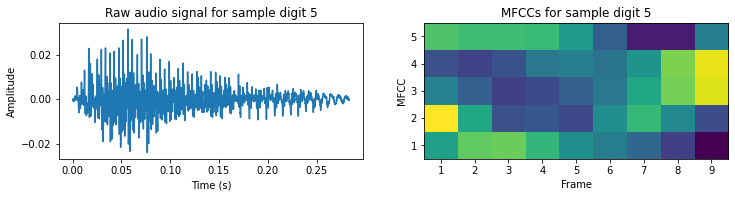

In [8]:
audio, mfcc, digit = X_train[0], mfcc_train[0], y_train[0]
time = np.linspace(0, len(audio) / spec_kwargs['sr'], num=len(audio))

# Raw audio
fig, axs = plt.subplots(ncols=2, figsize=(12, 2.5))
axs[0].set(title='Raw audio signal for sample digit {}'.format(digit), xlabel='Time (s)', ylabel='Amplitude')
axs[0].plot(time, audio)

# MFCCs
axs[1].imshow(np.swapaxes(mfcc, 0, 1), interpolation='nearest', cmap='viridis', origin='lower', aspect='auto')
axs[1].set(title='MFCCs for sample digit {}'.format(digit), xlabel='Frame', ylabel='MFCC',
    xticks=np.arange(len(mfcc)), xticklabels=np.arange(1, len(mfcc) + 1),
    yticks=np.arange(mfcc.shape[1]), yticklabels=np.arange(1, mfcc.shape[1] + 1))

plt.show()

Here is what the recording of this audio sounds like.

In [9]:
# Play the recording of the digit
play_audio(audio)

Note that when training and predicting, we rely on the Torch version of the dataset produced by `train_set.to_torch()`, so we must first update the data stored in the `train_set` object to use MFCC values, otherwise we would be using the original unprocessed audio signals.

In [10]:
# Use preprocessed MFCC sequences instead of raw audio
train_set.X = mfcc_train
test_set.X = mfcc_test

In [11]:
# Convert Dataset objects to Torch-compatible datasets
train_set_torch = train_set.to_torch()
test_set_torch = test_set.to_torch()

We now create PyTorch data loaders using these PyTorch datasets, along with the `collate_fn` function provided by Sequentia. The data loaders group together recordings of similar duration into a single batch, as specified by `collate_fn`. 

We use a batch size of 64 for the training set, and use single batch for the test set.

In [12]:
# Create training, validation and test set batch generators
train_gen = utils.data.DataLoader(train_set_torch, collate_fn=collate_fn, batch_size=64, shuffle=True, num_workers=0)
test_gen = utils.data.DataLoader(test_set_torch, collate_fn=collate_fn, batch_size=len(test_set), num_workers=0)

Next, we initialize the `DeepGRU` model by specifying the dimensions of the input, and the number of classes.

In [13]:
# Create a DeepGRU neural network model
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = DeepGRU(n_features=spec_kwargs['n_mfcc'], n_classes=10, device=device)

Next, we specify the negative log-likelihood loss function (which is also the same as cross entropy) as the optimization criterion, and apply the Adam learning rule to optimize the model parameters. 

In [14]:
# Set loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

We then run the typical PyTorch training loop for 10 epochs.

In [15]:
%%time

n_epoch = 10
for epoch in tqdm(range(n_epoch), desc='Epochs'):
    # Toggle training mode
    model.train()
    
    # Training loop
    for batch, lengths, labels in tqdm(train_gen, desc='Training batches', leave=True):
        # Send data to the device
        batch, lengths, labels = batch.to(device), lengths.to(device), labels.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Calculate predictions for batch
        log_prob = model(batch, lengths)
        y_pred = torch.argmax(log_prob, dim=1)
        
        # Calculate and back-propagate loss
        loss = criterion(log_prob, labels)
        loss.backward()
        
        # Update the optimizer
        optimizer.step()

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training batches:   0%|          | 0/38 [00:00<?, ?it/s]

Training batches:   0%|          | 0/38 [00:00<?, ?it/s]

Training batches:   0%|          | 0/38 [00:00<?, ?it/s]

Training batches:   0%|          | 0/38 [00:00<?, ?it/s]

Training batches:   0%|          | 0/38 [00:00<?, ?it/s]

Training batches:   0%|          | 0/38 [00:00<?, ?it/s]

Training batches:   0%|          | 0/38 [00:00<?, ?it/s]

Training batches:   0%|          | 0/38 [00:00<?, ?it/s]

Training batches:   0%|          | 0/38 [00:00<?, ?it/s]

Training batches:   0%|          | 0/38 [00:00<?, ?it/s]

CPU times: user 7min 58s, sys: 58.3 s, total: 8min 56s
Wall time: 5min 22s


Finally, we apply the model to the test set in evaluation mode to obtain a test accuracy and confusion matrix.

In [16]:
%%time

# Toggle evaluation mode
model.eval()

# Retrieve test set as a single batch
batch, lengths, labels = next(iter(test_gen))
# Send data to device
batch, lengths, labels = batch.to(device), lengths.to(device), labels.to(device)

# Calculate predictions for test set
y = model(batch, lengths)
y_pred = torch.argmax(y, dim=1)

CPU times: user 1.84 s, sys: 363 ms, total: 2.2 s
Wall time: 1.81 s


In [17]:
# Calculate accuracy
acc = torch.mean((labels == y_pred).float()).item()

# Calculate confusion matrix
classes = range(10)
cm = confusion_matrix(labels, y_pred, labels=classes)

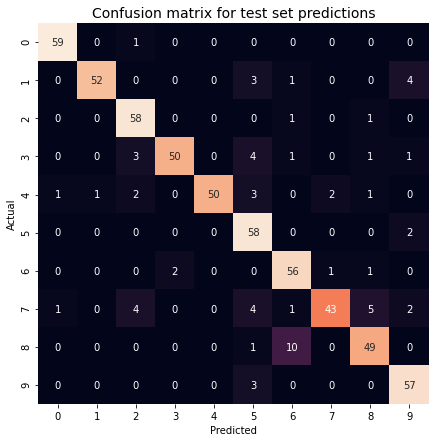

Accuracy: 88.67%


In [18]:
# Display accuracy and confusion matrix
df = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(7, 7))
sns.heatmap(df, annot=True, cbar=False)
plt.title('Confusion matrix for test set predictions', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(f'Accuracy: {(acc * 100):.2f}%')